## FUNCTIONS AND IMPORTS

In [1]:
import numpy as np
import struct
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [2]:
def load_mnist_images(filename):
    """Load MNIST images from a .idx3-ubyte file."""
    with open(filename, "rb") as f:
        magic, num_images, num_rows, num_cols = struct.unpack(">IIII", f.read(16))  # Read header
        images = np.frombuffer(f.read(), dtype=np.uint8)  # Read all pixel values
        images = images.reshape(num_images, num_rows, num_cols)  # Reshape to (num_images, 28, 28)
    return images

def load_mnist_labels(filename):
    """Load MNIST labels from a .idx1-ubyte file."""
    with open(filename, "rb") as f:
        magic, num_labels = struct.unpack(">II", f.read(8))  # Read header
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Read all labels
    return labels
# sampling data (100 each for train and test both)
def sample_n_per_class(X, Y, classes, n=100):
    """Randomly samples `n` images from each class in `classes`."""
    sampled_X, sampled_Y = [], []

    for digit in classes:
        indices = np.where(Y == digit)[0]  # Get indices of the class
        sampled_indices = np.random.choice(indices, n, replace=False)  # Randomly select `n`
        sampled_X.append(X[sampled_indices])  # Store selected images
        sampled_Y.append(Y[sampled_indices])  # Store corresponding labels

    # Convert lists to NumPy arrays
    return np.concatenate(sampled_X, axis=0), np.concatenate(sampled_Y, axis=0)
def gi_QDA_case3(mean , cov , x):
    mean = np.asarray(mean).reshape(-1, 1)
    cov = np.asarray(cov)
    x = np.asarray(x).reshape(-1, 1)
    
    diff = x - mean
    inv_cov = np.linalg.inv(cov)
    log_det = np.linalg.slogdet(cov)[1]  # Stable log determinant
    mahalanobis_dist = diff.T @ inv_cov @ diff  # Squared Mahalanobis distance
    
    return -0.5 * mahalanobis_dist - 0.5 * log_det
def gi_LDA_case2(mean , cov ,x):
    inv_cov = np.linalg.inv(cov)
    return ((inv_cov @ mean).T) @ x - 0.5 * mean.T @ inv_cov @ mean
import numpy as np

def compute_mean_and_covariance(data):
    data = np.real(data)  # Convert to real values
    d, n = data.shape  
    mean = np.sum(data, axis=1, keepdims=True) / n  

    covariance = np.zeros((d, d), dtype=np.float64)  # Ensure float64 type
    for i in range(n):
        diff = (data[:, i].reshape(d, 1) - mean)  
        covariance += diff @ diff.T  
    
    covariance /= (n - 1)  
    return mean, covariance


def gaussian(x, u, cov, inv, det):
    d = x.shape[0]
    u = u.reshape(d)
    a = (x - u).reshape(d, 1)
    delta = 1e-6 
    cov = cov + delta * np.eye(cov.shape[0])
    if det == 0:
        det = np.e**(-15)
    log_det = np.log(det)

    # Corrected Mahalanobis distance computation
    mahalanobis = (a.T @ inv @ a).item()  # Extract scalar from 1x1 matrix

    # Return log P(x) (without constant terms)
    return -0.5 * (mahalanobis + log_det)


## LOADING AND SAMPLING DATA

In [3]:
# Load training data
train_X = load_mnist_images("C:/Users/gulat_4p/Downloads/mnist/train-images.idx3-ubyte")
train_Y = load_mnist_labels("C:/Users/gulat_4p/Downloads/mnist/train-labels.idx1-ubyte")

# Load test data
test_X = load_mnist_images("C:/Users/gulat_4p/Downloads/mnist/t10k-images.idx3-ubyte")
test_y = load_mnist_labels("C:/Users/gulat_4p/Downloads/mnist/t10k-labels.idx1-ubyte")

# Check shapes
print(f"Train Images: {train_X.shape}, Train Labels: {train_Y.shape}")
print(f"Test Images: {test_X.shape}, Test Labels: {test_y.shape}")
mask = np.isin(train_Y,[0,1,2])
train_X = train_X[mask]
train_Y = train_Y[mask]
mask = np.isin(test_y,[0,1,2])
test_X = test_X[mask]
test_y = test_y[mask]
# flattening of images with numpy + noramlizing (0-1)
train_X = train_X.reshape(train_X.shape[0],28*28)/255.0
test_X = test_X.reshape(test_X.shape[0],28*28)/255.0
print(f"Train Images: {train_X.shape}, Train Labels: {train_Y.shape}")
print(f"Test Images: {test_X.shape}, Test Labels: {test_y.shape}")

Train Images: (60000, 28, 28), Train Labels: (60000,)
Test Images: (10000, 28, 28), Test Labels: (10000,)
Train Images: (18623, 784), Train Labels: (18623,)
Test Images: (3147, 784), Test Labels: (3147,)


In [4]:
# Sample from train set
sampled_train_X, sampled_train_Y = sample_n_per_class(train_X, train_Y, classes=[0, 1, 2], n=100)
# Sample from test set
sampled_test_X, sampled_test_Y = sample_n_per_class(test_X, test_y, classes=[0, 1, 2], n=100)
# Print the final shapes
print("Sampled Train X shape:", sampled_train_X.shape)  # (300, 784) after flattening
print("Sampled Train Y shape:", sampled_train_Y.shape)  # (300,)
print("Sampled Test X shape:", sampled_test_X.shape)  # (300, 784) after flattening
print("Sampled Test Y shape:", sampled_test_Y.shape)  # (300,)

Sampled Train X shape: (300, 784)
Sampled Train Y shape: (300,)
Sampled Test X shape: (300, 784)
Sampled Test Y shape: (300,)


In [5]:
PCA_2d_train_X = sampled_train_X
PCA_2d_train_Y = sampled_train_Y
PCA_2d_test_X = sampled_test_X
PCA_2d_test_Y = sampled_test_Y

## COMPUTING MLE ESTIMATES 
The MLE for a distribution coming from a multivariate gaussian distribution is given by: $$\hat \mu =  \frac{1}{m} \sum_{i=1}^m \mathbf{  x^{(i)} } = \mathbf{\bar{x}}$$
$$\hat \Sigma  = \frac{1}{m} \sum_{i=1}^m \mathbf{(x^{(i)} - \hat \mu) (x^{(i)} -\hat  \mu)}^T$$

In [6]:
# splitting data matrix into per class data matrices
X_0 = sampled_train_X[sampled_train_Y == 0]
X_1 = sampled_train_X[sampled_train_Y == 1]
X_2 = sampled_train_X[sampled_train_Y == 2]
mean_MLE_0 = np.zeros((784,))
mean_MLE_1 = np.zeros((784,))
mean_MLE_2 = np.zeros((784,))
cov_MLE_0 = np.zeros((784,784))
cov_MLE_1 = np.zeros((784,784))
cov_MLE_2 = np.zeros((784,784))
# computing MLE mean and covariance of given data (per class)
for i in range(100):
    mean_MLE_0 += X_0[i]
    mean_MLE_1 += X_1[i]
    mean_MLE_2 += X_2[i]
mean_MLE_0/=100.0
mean_MLE_1/=100.0
mean_MLE_2/=100.0
for i in range(100):
    cov_MLE_0 += (X_0[i] - mean_MLE_0) @ (X_0[i] - mean_MLE_0).T
    cov_MLE_1 += (X_1[i] - mean_MLE_1) @ (X_1[i] - mean_MLE_1).T
    cov_MLE_2 += (X_2[i] - mean_MLE_2) @ (X_2[i] - mean_MLE_2).T
cov_MLE_0/=100.0
cov_MLE_1/=100.0
cov_MLE_2/=100.0

In [7]:
MLE_train_X = sampled_train_X.T
MLE_test_X = sampled_test_X.T

In [8]:
cov_MLE_0_inv = np.linalg.inv(cov_MLE_0+0.0001*np.eye(784))
cov_MLE_1_inv = np.linalg.inv(cov_MLE_1+0.0001*np.eye(784))
cov_MLE_2_inv = np.linalg.inv(cov_MLE_2+0.0001*np.eye(784))
cov_MLE_0_det = np.linalg.det(cov_MLE_0+0.0001*np.eye(784))
cov_MLE_1_det = np.linalg.det(cov_MLE_1+0.0001*np.eye(784))
cov_MLE_2_det = np.linalg.det(cov_MLE_2+0.0001*np.eye(784))
mle_accuracy_train = 0
mle_accuracy_test = 0
for i in range(300):
    P0 = gaussian(MLE_train_X[:,i], mean_MLE_0,cov_MLE_0,cov_MLE_0_inv,cov_MLE_0_det)
    P1 = gaussian(MLE_train_X[:,i], mean_MLE_1,cov_MLE_1,cov_MLE_1_inv,cov_MLE_1_det)
    P2 = gaussian(MLE_train_X[:,i], mean_MLE_2,cov_MLE_2,cov_MLE_2_inv,cov_MLE_2_det)
    predicted_class = np.argmax([P0, P1, P2])
    true_class = sampled_train_Y[i]
    if predicted_class == true_class:
            mle_accuracy_train += 1
    P0 = gaussian(MLE_test_X[:,i], mean_MLE_0,cov_MLE_0,cov_MLE_0_inv,cov_MLE_0_det)
    P1 = gaussian(MLE_test_X[:,i], mean_MLE_1,cov_MLE_1,cov_MLE_1_inv,cov_MLE_1_det)
    P2 = gaussian(MLE_test_X[:,i], mean_MLE_2,cov_MLE_2,cov_MLE_2_inv,cov_MLE_2_det)
    predicted_class = np.argmax([P0, P1, P2])
    true_class = sampled_test_Y[i]
    if predicted_class == true_class:
            mle_accuracy_test += 1
mle_accuracy_train/=300
mle_accuracy_test/=300

In [9]:
print("MLE accuracy on training set: ",mle_accuracy_train)
print("MLE accuracy on test set: ",mle_accuracy_test)

MLE accuracy on training set:  0.94
MLE accuracy on test set:  0.91


## DIMENSIONALITY REDUCTION USING PCA 
Our data matrix is $X\in R^{784^{*}300}$ , each column represents 1 sample.

### RETAINING 95 % VARIANCE

In [10]:
PCA_X = sampled_train_X.T
mean_X = np.zeros((784))
for i in range(300):
    mean_X += PCA_X[:,i]
mean_X/=300
PCA_X_c = PCA_X - mean_X.reshape(784,1)
# Creating covariance matrix and getting the eigenvectors and values (sorted)
Cov_c = (PCA_X_c) @ (PCA_X_c).T
Cov_c/=(300-1)
# obtaining eigenvalues
eigenvalues , eigenvectors = np.linalg.eig(Cov_c)
# Sort indices based on eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]  # Descending order
# Sort eigenvalues & eigenvectors
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]  # Columns correspond to eigenvalues

In [11]:
# retaining 95% variance, obtaining U accordingly (=eigenvector matrix)
sum_ev = 0
for i in range(784):
    sum_ev+=eigenvalues[i]
target_sum = 0.95 * sum_ev
print(target_sum)
sum_ev = 0
for i in range(784):
    sum_ev+=eigenvalues[i]
    if sum_ev>target_sum:
        break
U = eigenvectors[:,:i+1]

(52.172005407224866+0j)


In [12]:
Y_PCA = U.T @ sampled_train_X.T  #PCA'd matrix
Y_PCA_test = U.T @ (sampled_test_X.T) #Test matrix post PCA

In [13]:
sampled_train_X = sampled_train_X.T
sampled_test_X = sampled_test_X.T

In [14]:
Y_PCA_0 = (Y_PCA.T[sampled_train_Y == 0]).T
Y_PCA_1 = (Y_PCA.T[sampled_train_Y == 1]).T
Y_PCA_2 = (Y_PCA.T[sampled_train_Y == 2]).T
mean_PCA_0 , cov_PCA_0 = compute_mean_and_covariance(Y_PCA_0)
mean_PCA_1 , cov_PCA_1 = compute_mean_and_covariance(Y_PCA_1)
mean_PCA_2 , cov_PCA_2 = compute_mean_and_covariance(Y_PCA_2)

In [15]:
# applying lDA on PCA'd train set and test set
cov_LDA_PCA = cov_PCA_0 + cov_PCA_1 + cov_PCA_2
cov_LDA_PCA/=3.0
accuracy_LDA_PCA_train = 0
accuracy_LDA_PCA_test = 0
for i in range(300):
        g0 = gi_LDA_case2(mean_PCA_0, cov_LDA_PCA, Y_PCA[:,i])
        g1 = gi_LDA_case2(mean_PCA_1, cov_LDA_PCA, Y_PCA[:,i])
        g2 = gi_LDA_case2(mean_PCA_2, cov_LDA_PCA, Y_PCA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_PCA_train += 1
        g0 = gi_LDA_case2(mean_PCA_0, cov_LDA_PCA, Y_PCA_test[:,i])
        g1 = gi_LDA_case2(mean_PCA_1, cov_LDA_PCA, Y_PCA_test[:,i])
        g2 = gi_LDA_case2(mean_PCA_2, cov_LDA_PCA, Y_PCA_test[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_PCA_test += 1
accuracy_LDA_PCA_train /= 300
accuracy_LDA_PCA_test /= 300

In [16]:
print("PCA->LDA accuracy on training set: ",accuracy_LDA_PCA_train)
print("PCA->LDA accuracy on test set: ",accuracy_LDA_PCA_test)

PCA->LDA accuracy on training set:  0.9966666666666667
PCA->LDA accuracy on test set:  0.9533333333333334


In [17]:
#APPLYING qda on pca'd test/train set
# applying QDA on PCA'd test set
accuracy_QDA_PCA_test = 0
accuracy_QDA_PCA_train = 0
for i in range(300):
        g0 = gi_QDA_case3(mean_PCA_0, cov_PCA_0, Y_PCA[:,i])
        g1 = gi_QDA_case3(mean_PCA_1, cov_PCA_1, Y_PCA[:,i])
        g2 = gi_QDA_case3(mean_PCA_2, cov_PCA_2, Y_PCA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_PCA_train += 1
        g0 = gi_QDA_case3(mean_PCA_0, cov_PCA_0, Y_PCA_test[:,i])
        g1 = gi_QDA_case3(mean_PCA_1, cov_PCA_1, Y_PCA_test[:,i])
        g2 = gi_QDA_case3(mean_PCA_2, cov_PCA_2, Y_PCA_test[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_PCA_test += 1
accuracy_QDA_PCA_test /= 300
accuracy_QDA_PCA_train /= 300

In [18]:
print("PCA->QDA accuracy on training set: ",accuracy_QDA_PCA_train)
print("PCA->QDA accuracy on test set: ",accuracy_QDA_PCA_test)

PCA->QDA accuracy on training set:  1.0
PCA->QDA accuracy on test set:  0.9233333333333333


### RETAINING 90% VARIANCE

In [19]:
# retaining 90% variance, obtaining U accordingly (=eigenvector matrix)
sum_ev = 0
for i in range(784):
    sum_ev+=eigenvalues[i]
target_sum = 0.9 * sum_ev
print(target_sum)
sum_ev = 0
for i in range(784):
    sum_ev+=eigenvalues[i]
    if sum_ev>target_sum:
        break
U = eigenvectors[:,:i+1]

(49.42611038579198+0j)


In [20]:
Y_PCA = U.T @ sampled_train_X  #PCA'd matrix
Y_PCA_test = U.T @ sampled_test_X #PCA'd test matrix

In [21]:
Y_PCA_0 = (Y_PCA.T[sampled_train_Y == 0]).T
Y_PCA_1 = (Y_PCA.T[sampled_train_Y == 1]).T
Y_PCA_2 = (Y_PCA.T[sampled_train_Y == 2]).T
mean_PCA_0 , cov_PCA_0 = compute_mean_and_covariance(Y_PCA_0)
mean_PCA_1 , cov_PCA_1 = compute_mean_and_covariance(Y_PCA_1)
mean_PCA_2 , cov_PCA_2 = compute_mean_and_covariance(Y_PCA_2)


In [22]:
# applying lDA on PCA'd train set and test set
cov_LDA_PCA = cov_PCA_0 + cov_PCA_1 + cov_PCA_2
cov_LDA_PCA/=3.0
accuracy_LDA_PCA_train = 0
accuracy_LDA_PCA_test = 0
for i in range(300):
        g0 = gi_LDA_case2(mean_PCA_0, cov_LDA_PCA, Y_PCA[:,i])
        g1 = gi_LDA_case2(mean_PCA_1, cov_LDA_PCA, Y_PCA[:,i])
        g2 = gi_LDA_case2(mean_PCA_2, cov_LDA_PCA, Y_PCA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_PCA_train += 1
        g0 = gi_LDA_case2(mean_PCA_0, cov_LDA_PCA, Y_PCA_test[:,i])
        g1 = gi_LDA_case2(mean_PCA_1, cov_LDA_PCA, Y_PCA_test[:,i])
        g2 = gi_LDA_case2(mean_PCA_2, cov_LDA_PCA, Y_PCA_test[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_PCA_test += 1
accuracy_LDA_PCA_train /= 300
accuracy_LDA_PCA_test /= 300

In [23]:
print("PCA->LDA accuracy on training set: ",accuracy_LDA_PCA_train)
print("PCA->LDA accuracy on test set: ",accuracy_LDA_PCA_test)

PCA->LDA accuracy on training set:  0.9966666666666667
PCA->LDA accuracy on test set:  0.9633333333333334


In [24]:
#APPLYING qda on pca'd test/train set
# applying QDA on PCA'd test set
accuracy_QDA_PCA_test = 0
accuracy_QDA_PCA_train = 0
for i in range(300):
        g0 = gi_QDA_case3(mean_PCA_0, cov_PCA_0, Y_PCA[:,i])
        g1 = gi_QDA_case3(mean_PCA_1, cov_PCA_1, Y_PCA[:,i])
        g2 = gi_QDA_case3(mean_PCA_2, cov_PCA_2, Y_PCA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_PCA_train += 1
        g0 = gi_QDA_case3(mean_PCA_0, cov_PCA_0, Y_PCA_test[:,i])
        g1 = gi_QDA_case3(mean_PCA_1, cov_PCA_1, Y_PCA_test[:,i])
        g2 = gi_QDA_case3(mean_PCA_2, cov_PCA_2, Y_PCA_test[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_PCA_test += 1
accuracy_QDA_PCA_test /= 300
accuracy_QDA_PCA_train /= 300

In [25]:
print("PCA->QDA accuracy on training set: ",accuracy_QDA_PCA_train)
print("PCA->QDA accuracy on test set: ",accuracy_QDA_PCA_test)

PCA->QDA accuracy on training set:  1.0
PCA->QDA accuracy on test set:  0.9633333333333334


## USING ONLY FIRST 2 PRINCIPAL COMPONENTS

In [26]:
U_2 = eigenvectors[:,:2]
Y_PCA = U_2.T @ PCA_2d_train_X.T
Y_PCA_test = U_2.T @ PCA_2d_test_X.T

In [27]:
Y_PCA_0 = (Y_PCA.T[sampled_train_Y == 0]).T
Y_PCA_1 = (Y_PCA.T[sampled_train_Y == 1]).T
Y_PCA_2 = (Y_PCA.T[sampled_train_Y == 2]).T
mean_PCA_0 , cov_PCA_0 = compute_mean_and_covariance(Y_PCA_0)
mean_PCA_1 , cov_PCA_1 = compute_mean_and_covariance(Y_PCA_1)
mean_PCA_2 , cov_PCA_2 = compute_mean_and_covariance(Y_PCA_2)

In [28]:
# applying lDA on PCA'd train set and test set
cov_LDA_PCA = cov_PCA_0 + cov_PCA_1 + cov_PCA_2
cov_LDA_PCA/=3.0
accuracy_LDA_PCA_train = 0
accuracy_LDA_PCA_test = 0
for i in range(300):
        g0 = gi_LDA_case2(mean_PCA_0, cov_LDA_PCA, Y_PCA[:,i])
        g1 = gi_LDA_case2(mean_PCA_1, cov_LDA_PCA, Y_PCA[:,i])
        g2 = gi_LDA_case2(mean_PCA_2, cov_LDA_PCA, Y_PCA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_PCA_train += 1
        g0 = gi_LDA_case2(mean_PCA_0, cov_LDA_PCA, Y_PCA_test[:,i])
        g1 = gi_LDA_case2(mean_PCA_1, cov_LDA_PCA, Y_PCA_test[:,i])
        g2 = gi_LDA_case2(mean_PCA_2, cov_LDA_PCA, Y_PCA_test[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_PCA_test += 1
accuracy_LDA_PCA_train /= 300
accuracy_LDA_PCA_test /= 300

In [29]:
print("PCA->LDA accuracy on training set: ",accuracy_LDA_PCA_train)
print("PCA->LDA accuracy on test set: ",accuracy_LDA_PCA_test)

PCA->LDA accuracy on training set:  0.9166666666666666
PCA->LDA accuracy on test set:  0.8633333333333333


In [30]:
#APPLYING qda on pca'd test/train set
# applying QDA on PCA'd test set
accuracy_QDA_PCA_test = 0
accuracy_QDA_PCA_train = 0
for i in range(300):
        g0 = gi_QDA_case3(mean_PCA_0, cov_PCA_0, Y_PCA[:,i])
        g1 = gi_QDA_case3(mean_PCA_1, cov_PCA_1, Y_PCA[:,i])
        g2 = gi_QDA_case3(mean_PCA_2, cov_PCA_2, Y_PCA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_PCA_train += 1
        g0 = gi_QDA_case3(mean_PCA_0, cov_PCA_0, Y_PCA_test[:,i])
        g1 = gi_QDA_case3(mean_PCA_1, cov_PCA_1, Y_PCA_test[:,i])
        g2 = gi_QDA_case3(mean_PCA_2, cov_PCA_2, Y_PCA_test[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_PCA_test += 1
accuracy_QDA_PCA_test /= 300
accuracy_QDA_PCA_train /= 300

In [31]:
print("PCA->QDA accuracy on training set: ",accuracy_QDA_PCA_train)
print("PCA->QDA accuracy on test set: ",accuracy_QDA_PCA_test)

PCA->QDA accuracy on training set:  0.94
PCA->QDA accuracy on test set:  0.9


## CLASS PROJECTION USING FDA

In [32]:
# splitting data matrix into per class data matrices
sampled_train_X = sampled_train_X.T
sampled_test_X = sampled_test_X.T
X_0 = sampled_train_X[sampled_train_Y == 0].T
X_1 = sampled_train_X[sampled_train_Y == 1].T
X_2 = sampled_train_X[sampled_train_Y == 2].T
mean_fda_0 = np.zeros((784,))
mean_fda_1 = np.zeros((784,))
mean_fda_2 = np.zeros((784,))
for i in range(100):
    mean_fda_0 += X_0[:,i]
    mean_fda_1 += X_1[:,i]
    mean_fda_2 += X_2[:,i]
mean_fda_0/=100.0
mean_fda_1/=100.0
mean_fda_2/=100.0
global_mean = (mean_fda_0+mean_fda_1+mean_fda_2)/3.0
# making the within class scatter matrix
S_w = np.zeros((784,784))
for i in range(100):
    S_w += (X_0[:,i] - mean_fda_0) @ (X_0[:,i] - mean_fda_0).T
for i in range(100):
    S_w += (X_1[:,i] - mean_fda_1) @ (X_1[:,i] - mean_fda_1).T
for i in range(100):
    S_w += (X_2[:,i] - mean_fda_2) @ (X_2[:,i] - mean_fda_2).T
S_b = (mean_fda_0.reshape(784,1) - mean_fda_1.reshape(784,1)) @ (mean_fda_0.reshape(784,1) - mean_fda_1.reshape(784,1)).T + (mean_fda_1.reshape(784,1) - mean_fda_2.reshape(784,1)) @ (mean_fda_1.reshape(784,1) - mean_fda_2.reshape(784,1)).T + (mean_fda_0.reshape(784,1) - mean_fda_2.reshape(784,1)) @ (mean_fda_0.reshape(784,1) - mean_fda_2.reshape(784,1)).T

In [ ]:
eigvals, eigvecs = eigh(S_b, S_w+0.00001*np.eye(784), eigvals_only=False)
# Sorting eigenvalues in descending order and reordering eigenvectors
sorted_indices = np.argsort(eigvals)[::-1]  # Get indices in descending order
eigvals = eigvals[sorted_indices]  # Sort eigenvalues
eigvecs = eigvecs[:, sorted_indices]  # Sort eigenvectors accordingly
# since c-1 = 3-1 = 2 , we choose the 2 highest eigenvectors
W = eigvecs[:,:2]


In [34]:
X_0_test = sampled_test_X[sampled_test_Y == 0].T
X_1_test = sampled_test_X[sampled_test_Y == 1].T
X_2_test = sampled_test_X[sampled_test_Y == 2].T

In [35]:
# applying FDA on train set and test set
FDA_0 = W.T @ X_0
FDA_1 = W.T @ X_1
FDA_2 = W.T @ X_2
mean_FDA_0 , cov_FDA_0 = compute_mean_and_covariance(FDA_0)
mean_FDA_1 , cov_FDA_1 = compute_mean_and_covariance(FDA_1)
mean_FDA_2 , cov_FDA_2 = compute_mean_and_covariance(FDA_2)

In [36]:
sampled_train_X = sampled_train_X.T
sampled_test_X = sampled_test_X.T

In [37]:
sampled_train_X_FDA = W.T @ sampled_train_X
sampled_test_X_FDA = W.T @ sampled_test_X

In [38]:
# applying lDA on FDA'd train set and test set
cov_LDA_FDA = cov_FDA_0 + cov_FDA_1 + cov_FDA_2
cov_LDA_FDA/=3.0
accuracy_LDA_FDA_train = 0
accuracy_LDA_FDA_test = 0
for i in range(300):
        g0 = gi_LDA_case2(mean_FDA_0, cov_LDA_FDA, sampled_train_X_FDA[:,i])
        g1 = gi_LDA_case2(mean_FDA_1, cov_LDA_FDA, sampled_train_X_FDA[:,i])
        g2 = gi_LDA_case2(mean_FDA_2, cov_LDA_FDA, sampled_train_X_FDA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_FDA_train += 1
        g0 = gi_LDA_case2(mean_FDA_0, cov_LDA_FDA, sampled_test_X_FDA[:,i])
        g1 = gi_LDA_case2(mean_FDA_1, cov_LDA_FDA, sampled_test_X_FDA[:,i])
        g2 = gi_LDA_case2(mean_FDA_2, cov_LDA_FDA, sampled_test_X_FDA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_LDA_FDA_test += 1
accuracy_LDA_FDA_train /= 300
accuracy_LDA_FDA_test /= 300
print(accuracy_LDA_FDA_train , accuracy_LDA_FDA_test)

0.94 0.91


In [39]:
# applying QDA on FDA'd test set
accuracy_QDA_FDA_test = 0
accuracy_QDA_FDA_train = 0
for i in range(300):
        g0 = gi_QDA_case3(mean_FDA_0, cov_FDA_0, sampled_train_X_FDA[:,i])
        g1 = gi_QDA_case3(mean_FDA_1, cov_FDA_1, sampled_train_X_FDA[:,i])
        g2 = gi_QDA_case3(mean_FDA_2, cov_FDA_2, sampled_train_X_FDA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_train_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_FDA_train += 1
        g0 = gi_QDA_case3(mean_FDA_0, cov_FDA_0, sampled_test_X_FDA[:,i])
        g1 = gi_QDA_case3(mean_FDA_1, cov_FDA_1, sampled_test_X_FDA[:,i])
        g2 = gi_QDA_case3(mean_FDA_2, cov_FDA_2, sampled_test_X_FDA[:,i])
        
        predicted_class = np.argmax([g0, g1, g2])
        true_class = sampled_test_Y[i]  # Assuming a function to get true labels
        
        if predicted_class == true_class:
            accuracy_QDA_FDA_test += 1
accuracy_QDA_FDA_test /= 300
accuracy_QDA_FDA_train /= 300
print(accuracy_QDA_FDA_train,accuracy_QDA_FDA_test)

0.9533333333333334 0.9333333333333333


## DISPLAYING DATA

### DISPLAYING FDA'D DATA (2 dimensions)

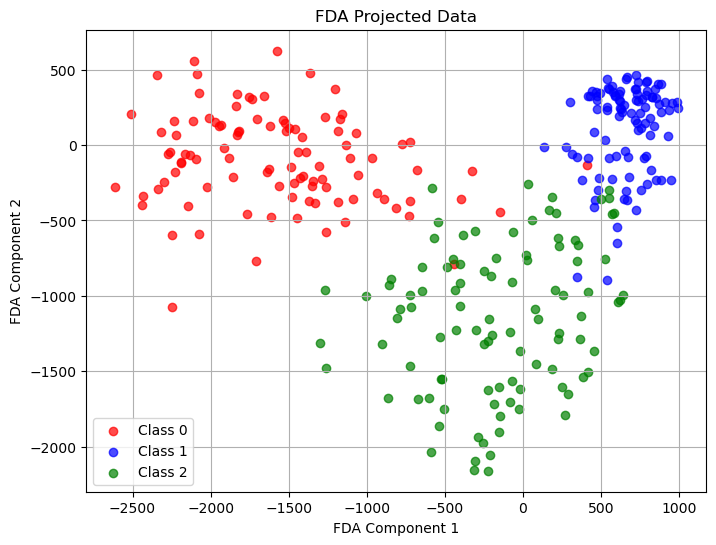

In [40]:


# Assuming W.T @ X_* results in a 2x100 matrix
# Concatenating all data matrices for plotting
FDA_all = np.hstack([FDA_0, FDA_1, FDA_2])  # Shape: (2, 300)
labels = sampled_train_Y  # Shape: (300,)

# Define colors for each class
colors = ['red', 'blue', 'green']
class_labels = np.unique(labels)  # Unique class labels

# Plotting
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_labels):
    indices = np.where(labels == class_label)[0]
    plt.scatter(FDA_all[0, indices], FDA_all[1, indices], 
                color=colors[i], label=f'Class {class_label}', alpha=0.7)

plt.xlabel('FDA Component 1')
plt.ylabel('FDA Component 2')
plt.title('FDA Projected Data')
plt.legend()
plt.grid()
plt.show()


### DISPLAYING PCA'D DATA (WHERE ONLY FIRST 2 PRINCIPAL COMPONENTS USED)

C:\Users\gulat_4p\anaconda3\Lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


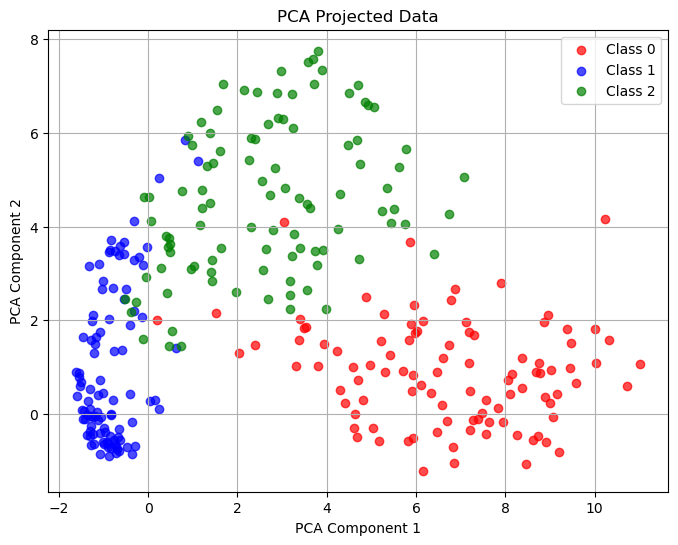

In [41]:
# Assuming Y_PCA is of shape (2, 300)# Labels are in sampled_train_Y of shape (300,)

# Define unique labels and corresponding colors
unique_labels = np.unique(sampled_train_Y)
colors = ['red', 'blue', 'green', 'purple', 'orange']  # Adjust if more classes exist

# Plotting
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    indices = np.where(sampled_train_Y == label)[0]  # Find indices for the class
    plt.scatter(Y_PCA[0, indices], Y_PCA[1, indices], 


                
                color=colors[i % len(colors)], label=f'Class {label}', alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projected Data')
plt.legend()
plt.grid()
plt.show()
